In [1]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import StratifiedKFold, cross_val_score


In [2]:
RND = 42

# -------------------------
# 1) Load data
train = pd.read_csv(r"C:\Users\Dell\Desktop\intershp\New folder\train.csv")
test  = pd.read_csv(r"C:\Users\Dell\Desktop\intershp\New folder\test.csv")
sample = pd.read_csv(r"C:\Users\Dell\Desktop\intershp\New folder\sample_submission.csv")  # template for submission
ID_COL = "ID"
TARGET = "Segmentation"


In [3]:
# quick clean: trim whitespace in string columns
def strip_strings(df):
    df.columns = df.columns.str.strip()
    for c in df.select_dtypes(include="object").columns:
        df[c] = df[c].astype(str).str.strip()
    return df

train = strip_strings(train)
test  = strip_strings(test)

In [11]:
# -------------------------
# 2) Feature list (keep it simple and consistent)
features = ["Gender", "Ever_Married", "Age", "Graduated",
            "Profession", "Work_Experience", "Spending_Score",
            "Family_Size", "Var_1"]

X = train[features].copy()
y = train[TARGET].copy()
X_test = test[features].copy()

# coerce numeric columns (bad strings -> NaN so imputer can handle them)
for col in ["Age", "Work_Experience", "Family_Size"]:
    if col in X.columns:
        X[col] = pd.to_numeric(X[col], errors="coerce")
        X_test[col] = pd.to_numeric(X_test[col], errors="coerce")

# map spending to an ordinal numeric (Low < Average < High)
sp_map = {"Low": 0, "Average": 1, "High": 2}
train["Spending_Score"] = train["Spending_Score"].map(sp_map).astype(float)
for df in (X, X_test):
    df["Spending_Score"] = (
        df["Spending_Score"].map(sp_map).fillna(1).astype(float)
    )


In [12]:
# 3) Preprocessing: numeric & categorical

num_cols = ["Age", "Work_Experience", "Family_Size", "Spending_Score"]
cat_cols = ["Gender", "Ever_Married", "Graduated", "Profession", "Var_1"]

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),   # fill missing numeric with median
    ("scale", StandardScaler())                     # standardize numeric features
])

cat_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),  # fill missing categorical with mode
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols),
], remainder="drop")


In [31]:

# Apply preprocessing to data
processed = preprocessor.fit_transform(df)

# Get feature names (after OHE expansion)
feature_names = (
    num_cols + 
    list(preprocessor.named_transformers_["cat"]["ohe"].get_feature_names_out(cat_cols))
)

# Recreate DataFrame with transformed data
df_processed = pd.DataFrame(processed, columns=feature_names)

# Verify no missing values
print(df_processed.isnull().sum())


Age                         0
Work_Experience             0
Family_Size                 0
Spending_Score              0
Gender_Female               0
Gender_Male                 0
Ever_Married_No             0
Ever_Married_Yes            0
Ever_Married_nan            0
Graduated_No                0
Graduated_Yes               0
Graduated_nan               0
Profession_Artist           0
Profession_Doctor           0
Profession_Engineer         0
Profession_Entertainment    0
Profession_Executive        0
Profession_Healthcare       0
Profession_Homemaker        0
Profession_Lawyer           0
Profession_Marketing        0
Profession_nan              0
Var_1_Cat_1                 0
Var_1_Cat_2                 0
Var_1_Cat_3                 0
Var_1_Cat_4                 0
Var_1_Cat_5                 0
Var_1_Cat_6                 0
Var_1_Cat_7                 0
Var_1_nan                   0
dtype: int64


In [19]:
# # 4) Quick clustering (k=4) for insight
# # Fit preprocessor on combined data so categories include test values too
# all_X = pd.concat([X, X_test], axis=0).reset_index(drop=True)
# Z_all = preprocessor.fit_transform(all_X)   # numpy array

# k = 4
# kmeans = KMeans(n_clusters=k, random_state=RND, n_init=10)
# clusters = kmeans.fit_predict(Z_all)

# # separate clusters back to train/test
# train_clusters = clusters[: len(X)]
# test_clusters  = clusters[len(X):]

# # optional: silhouette score to check cluster quality (higher is better, max 1)
# try:
#     sil = silhouette_score(Z_all, clusters)
#     print(f"Silhouette score (all data, k={k}): {sil:.3f}")
# except Exception:
#     pass

# # attach cluster to train for quick profiling
# train["Cluster"] = train_clusters

# print("Cluster sizes:\n", train["Cluster"].value_counts())


# 4) Quick clustering (k=4) for insight
# Fit preprocessor on combined data so categories include test values too
all_X = pd.concat([X, X_test], axis=0).reset_index(drop=True)
Z_all = preprocessor.fit_transform(all_X)   # numpy array

k = 4
kmeans = KMeans(n_clusters=k, random_state=RND, n_init=10)
clusters = kmeans.fit_predict(Z_all)

# separate clusters back to train/test
train_clusters = clusters[: len(X)]
test_clusters  = clusters[len(X):]

# optional: silhouette score to check cluster quality (higher is better, max 1)
try:
    sil = silhouette_score(Z_all, clusters)
    print(f"Silhouette score (all data, k={k}): {sil:.3f}")
except Exception:
    pass

# attach cluster to train for quick profiling
train["Cluster"] = train_clusters

print("Cluster sizes:\n", train["Cluster"].value_counts())

# (NEW CODE #1) --- Customer Persona Profiles ---



Silhouette score (all data, k=4): 0.182
Cluster sizes:
 Cluster
0    2747
1    2048
2    1849
3    1424
Name: count, dtype: int64


In [20]:
# Calculate mean stats per cluster
cluster_profiles = train.groupby("Cluster").agg({
    "Age": "mean",
    "Work_Experience": "mean",
    "Family_Size": "mean",
    "Spending_Score": "mean"
}).round(2)

print("\nCluster Profiles (averages):\n", cluster_profiles)

# (NEW CODE #2) --- Translate into customer personas ---
personas = {
    0: "Older professionals with moderate families and higher spending",
    1: "Middle-aged individuals, smaller families, cautious spenders",
    2: "Young adults, larger families, very low spending",
    3: "Mid-career workers with high work experience, average spending"
}

print("\nCustomer Personas:")
for c in cluster_profiles.index:
    print(f"Cluster {c}: {personas[c]}")



Cluster Profiles (averages):
            Age  Work_Experience  Family_Size  Spending_Score
Cluster                                                     
0        53.03             1.31         3.08            1.41
1        49.77             0.93         1.63            0.00
2        27.06             1.36         4.25            0.03
3        37.25             8.52         2.35            0.33

Customer Personas:
Cluster 0: Older professionals with moderate families and higher spending
Cluster 1: Middle-aged individuals, smaller families, cautious spenders
Cluster 2: Young adults, larger families, very low spending
Cluster 3: Mid-career workers with high work experience, average spending


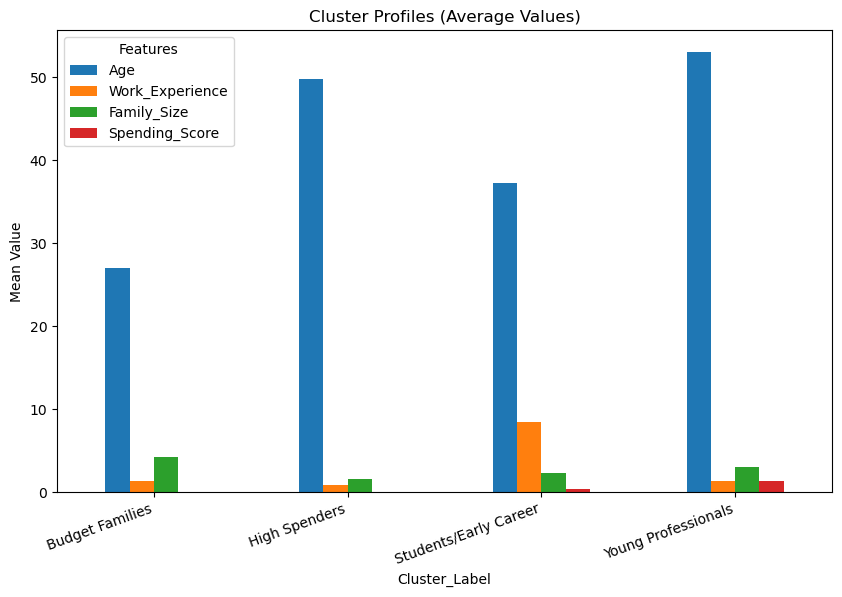

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns


# --- Code 5: Visualization of Cluster Profiles with Labels ---

# Define cluster labels (you can adjust after checking profile values)
cluster_labels = {
    0: "Young Professionals",
    1: "High Spenders",
    2: "Budget Families",
    3: "Students/Early Career"
}

# Replace cluster numbers with labels
train["Cluster_Label"] = train["Cluster"].map(cluster_labels)

# Recompute profiles with labels
profiles = train.groupby("Cluster_Label")[["Age","Work_Experience","Family_Size","Spending_Score"]].mean()

# 1) Barplot of averages per cluster
profiles.plot(kind="bar", figsize=(10,6))
plt.title("Cluster Profiles (Average Values)")
plt.ylabel("Mean Value")
plt.xticks(rotation=20, ha="right")
plt.legend(title="Features")
plt.show()



In [9]:
# 5) Classification: train model to predict Segmentation on TEST
# encode target labels A/B/C/D -> integers
lbl = LabelEncoder()
y_enc = lbl.fit_transform(y)

clf = Pipeline([
    ("preproc", preprocessor), 
    ("model", RandomForestClassifier(n_estimators=200, random_state=RND, n_jobs=-1))
])

# quick cross-validated check (f1_macro)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RND)
scores = cross_val_score(clf, X, y_enc, cv=cv, scoring="f1_macro", n_jobs=-1)
print(f"CV f1_macro mean: {scores.mean():.3f}  std: {scores.std():.3f}")

# fit on all train, predict test
clf.fit(X, y_enc)
pred_enc = clf.predict(X_test)
pred = lbl.inverse_transform(pred_enc)   # back to labels A/B/C/D

CV f1_macro mean: 0.477  std: 0.009


In [32]:

# 6) Build submission (use test IDs - aligns with most competitions)
submission = pd.DataFrame({ID_COL: test[ID_COL].values, "Segmentation": pred})
submission.to_csv("submission.csv", index=False)
print("Saved submission.csv with", submission.shape[0], "rows")

# -------------------------
# 7) Quick profiling output you can paste in report
profile = train.groupby("Segmentation").agg({
    "Age": "mean", "Work_Experience": "mean", "Family_Size": "mean", "Spending_Score": "mean"
}).round(2)
print("\nSimple profile by true Segmentation:\n", profile)


Saved submission.csv with 2627 rows

Simple profile by true Segmentation:
                 Age  Work_Experience  Family_Size  Spending_Score
Segmentation                                                     
A             44.92             2.87         2.44            0.45
B             48.20             2.38         2.70            0.73
C             49.14             2.24         2.97            0.87
D             33.39             3.02         3.23            0.20
